## Import libraries and copy of dataset including extracted features

In [1]:
from PIL import Image, ImageStat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import pywt
from skimage.feature import greycomatrix,greycoprops 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold,cross_validate,learning_curve,GridSearchCV,train_test_split
from sklearn import svm, discriminant_analysis,neighbors,naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix,precision_recall_fscore_support,accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from imblearn.over_sampling import SVMSMOTE,ADASYN
import seaborn as sns
from mlxtend.plotting import plot_pca_correlation_graph
import numpy as np
from sklearn.datasets import make_classification
import torch
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

# Load file names and labels
df = pd.read_csv('dataset/label_data.csv')    

# Data preprocessing

A histogram of the different classes in the training set reveals a large imbalance between tumourous and non-tumourous classes. This imbalance will produce an statistical bias of classifiers towards tumourous classes since selecting a new sample as tumourous has an underlying 75% probablity of being correct. 

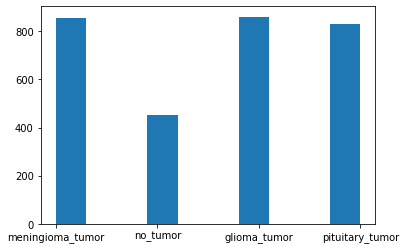

In [5]:
plt.hist(df['label'])
plt.show()

There are two general ways in which imbalanced datasets can be handled. One option is to perform under-sampling of the dominant classes, this process ensures all remaining datapoints are real and a good representation of the class (subject to an unbiased sample removal) but implies reducing the size of the training data. Another option is to over-sample the minority class by either repeating existing datapoints or statiatically synthesising new points, this method increases the size of the training data but is not as accurate as under-sampling because the new datapoints are not real samples. It is also common to perform both methods sequentially to generate new points and then clear up the feature space.

Given that the size of the training data is low (relative to deep learning techniques requirements) over-sampling was chosen as dataset balancing method. Particularly, the Support Vector Machine (SVM) variant of the Synthetic Minority Over-sampling Technique (SMOTE) algorithm was chosen as over-sampling method since it is designed to amplify the number of datapoints by connecting inliers and outliers in the minority class while giving a greater preference to outliers. SVMSMOTE ensures new datapoints are balanced but also harder to classify, hence implying that good results from classifiers will be due to correct feature selection rather than meaningless clearly separated samples. 

In [63]:
# Create a feature matrix X(NxM) where N = number of data samples and M = number of features 
# Create a labels vector y(Nx1)
X = df.iloc[:,5:].to_numpy() # remove the first 5 columns since they are not features
y = df['tumour']

scaler = MinMaxScaler() # normalise data
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.2)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Use SVMSMOTE to over-sample the dataset
X_resampled,y_resampled = SVMSMOTE().fit_resample(X_train,y_train)

print(np.shape(X_resampled))
print(np.shape(y_resampled))

(4074, 44)
(4074,)


# Task A

## Feature extraction

Simple initial features such as average pixel intensity, entropy, etc.

In [187]:
# Loop over all images and calculate simple initial features such as average pixel intensity, entropy, etc.
avg = []
ent = []
var = []
ratioh = []
ratiov = []
ratiod = []
rms = []
median = []
sum2 = []
sum1 = []
for idx,filename in enumerate(df.loc[:,'file_name']):
    im = Image.open('dataset/image/'+filename).convert('L')
    ent.append(im.entropy())
    avg.append(ImageStat.Stat(im).mean[0])
    median.append(ImageStat.Stat(im).median[0])
    var.append(ImageStat.Stat(im).var[0])
    rms.append(ImageStat.Stat(im).rms[0])
    sum2.append(ImageStat.Stat(im).sum2[0])
    sum1.append(ImageStat.Stat(im).sum1[0])

    im = np.array(im) # convert to numpy array
    left=0
    right=0
    top=0
    bottom=0
    topd=0
    bottomd=0
    for j in range(0,512):
        for k in range(0,512):
            if k>=256:
                top = top+im[j,k]
            else:
                bottom = bottom+im[j,k]
            
            if j>=256:
                right = right+im[j,k]
            else:
                left = left+im[j,k]
            if j>k:
                topd = topd+im[j,k]
            else:
                bottomd = bottomd+im[j,k]

    ratiov.append(left/right)
    ratioh.append(top/bottom)
    ratiod.append(topd/bottomd)

df['entropy'] = ent
df['variance'] = var
df['avg_pixel_intensity'] = avg
df['pixel_sum'] = sum1
df['pixel_sum_squared'] = sum2
df['median'] = median
df['rms'] = rms
df['Horizontal symmetry'] = ratioh
df['Vertical symmetry'] = ratiov
df['Diagonal symmetry'] = ratiod

Correlation between images and archetypical or average images (mostly for different perspectives) 

In [5]:
# Testing how correlation between example images from each perspective help classifying them - top correlation seems useful 
corr_front = []
corr_side = []
corr_top = []
side = Image.open('dataset/image/IMAGE_0000.jpg').convert('L')
front = Image.open('dataset/image/IMAGE_0011.jpg').convert('L')
top = Image.open('dataset/image/IMAGE_0001.jpg').convert('L')
for idx,filename in enumerate(df.loc[:150,'file_name']):
    im = Image.open('dataset/image/'+filename).convert('L')
    corr_front.append(np.mean(signal.correlate2d(np.array(front),np.array(im))))
    corr_side.append(np.mean(signal.correlate2d(np.array(side),np.array(im))))
    corr_top.append(np.mean(signal.correlate2d(np.array(top),np.array(im))))

df.loc[:150,'corr_front'] = corr_front
df.loc[:150,'corr_side'] = corr_side
df.loc[:150,'corr_top'] = corr_top

ax = df[df['perspective']=='top'].plot('corr_top','Horizontal symmetry',kind='scatter',color='green',label='Top')
df[df['perspective']=='side'].plot('corr_top','Horizontal symmetry',kind='scatter',color='red',ax=ax,label='Side')
df[df['perspective']=='front'].plot('corr_top','Horizontal symmetry',kind='scatter',color='blue',ax=ax,label='Front')


Wavelet transforms and GLCM features

symmetric
True
False


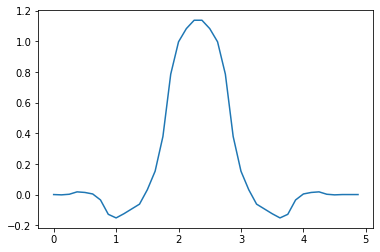

In [12]:
wavelet = pywt.Wavelet('bior1.3')
[phi_d, psi_d, phi_r, psi_r, x] = wavelet.wavefun(level=3)
plt.plot(x,phi_d)

print(wavelet.symmetry)
print(wavelet.biorthogonal)
print(wavelet.orthogonal)

In [107]:
feature1 = []
feature2 = []
feature3 = []
feature4 = []
feature5 = []
feature6 = []
for idx,filename in enumerate(df.loc[:,'file_name']):
    im = Image.open('dataset/image/'+filename).convert('L')
    im = np.array(im)
    LL1, (LH,HL,HH) = pywt.dwt2(im,'bior1.3')
    _, (LH2,HL2,HH2) = pywt.dwt2(LL1,'bior1.3')
    HH = ((HH - HH.min()) * (1/(HH.max() - HH.min()) * 255)).astype('uint8') # convert to 0-255 scale
    glcm = greycomatrix(HH,distances=[5],angles=[0])
    feature1.append(greycoprops(glcm,prop='correlation')[0][0])
    feature2.append(greycoprops(glcm,prop='contrast')[0][0])
    feature3.append(greycoprops(glcm,prop='homogeneity')[0][0])
    feature4.append(greycoprops(glcm,prop='dissimilarity')[0][0])
    feature5.append(greycoprops(glcm,prop='ASM')[0][0])
    feature6.append(greycoprops(glcm,prop='energy')[0][0])

df['corr_HH'] = feature1
df['contrast_HH'] = feature2
df['homogeneity_HH'] = feature3
df['dissimilarity_HH'] = feature4
df['ASM_HH'] = feature5
df['energy_HH'] = feature6

## Feature selection

### Perform dimensionality reduction

First, study the importance of principal axis by means of a scree plot. Second, generate a correlation circle to study the influence of individual features.

[0.67685686 0.08803337 0.04683553 0.03173334 0.02491013 0.02168129
 0.01704923 0.01474317 0.01256275 0.01019138 0.00787145 0.0074392
 0.00697743 0.0066417  0.00509686 0.00398815 0.00346635 0.0031619
 0.00216313 0.00167832]


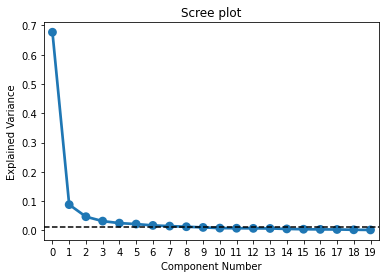

                        Dim 1     Dim 2
entropy             -0.947389 -0.023092
variance            -0.131160  0.801882
median              -0.813442  0.230914
Horizontal symmetry -0.182188 -0.081846
Vertical symmetry   -0.121762 -0.130407
Diagonal symmetry    0.229680  0.133130
pixel_sum_squared   -0.668842  0.525088
std                 -0.151645  0.814154
corr_LH             -0.117842  0.261286
contrast_LH         -0.601733  0.328903
homogeneity_LH       0.982192  0.096053
dissimilarity_LH    -0.819426  0.222457
ASM_LH               0.963397  0.139022
energy_LH            0.980334  0.158470
corr_HL              0.045614  0.120683
contrast_HL         -0.415811  0.595480
homogeneity_HL       0.977788  0.015710
dissimilarity_HL    -0.652743  0.492088
ASM_HL               0.963522  0.128462
energy_HL            0.982275  0.128890
corr_HH              0.167577 -0.054814
contrast_HH         -0.549266  0.237682
homogeneity_HH       0.965003  0.079497
dissimilarity_HH    -0.777931  0.156051


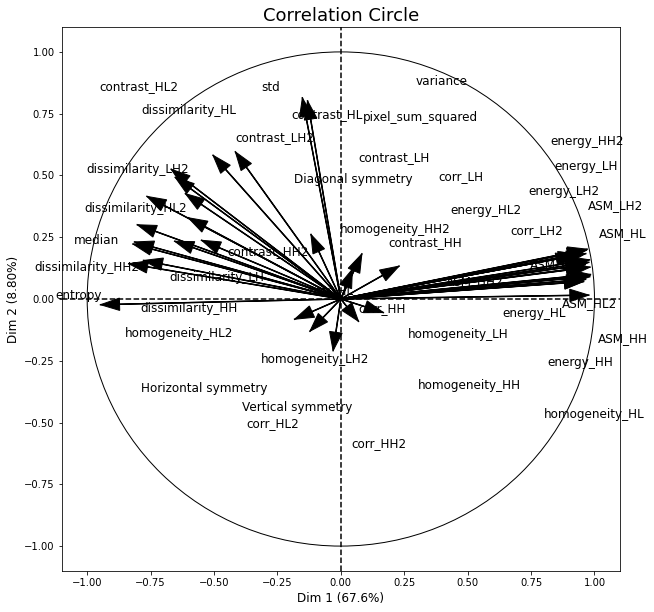

In [7]:
# Perform PCA to reduce all initial features into principal components

n_components = 20

pca = PCA(n_components=n_components)
pca.fit(scaler.transform(X))
print(pca.explained_variance_ratio_)

# Get datapoints projected to 10 principal components space
res = pca.transform(scaler.transform(X))

# Generate scree plot
ind = np.arange(0, n_components)
(fig, ax) = plt.subplots()
sns.pointplot(x=ind, y=pca.explained_variance_ratio_)
ax.axhline(0.01,color='black',linestyle='--')
ax.set_title('Scree plot')
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance')
plt.show()

# Plot correlation circle to study the influence of each feature in clustering
fig,corr_matrix = plot_pca_correlation_graph(scaler.transform(X),df.iloc[:,5:].columns) # feature normalisation ensures relative values
print(corr_matrix)
fig.set_figheight(10)
fig.set_figwidth(10)

Generate a more clearly labelled representation

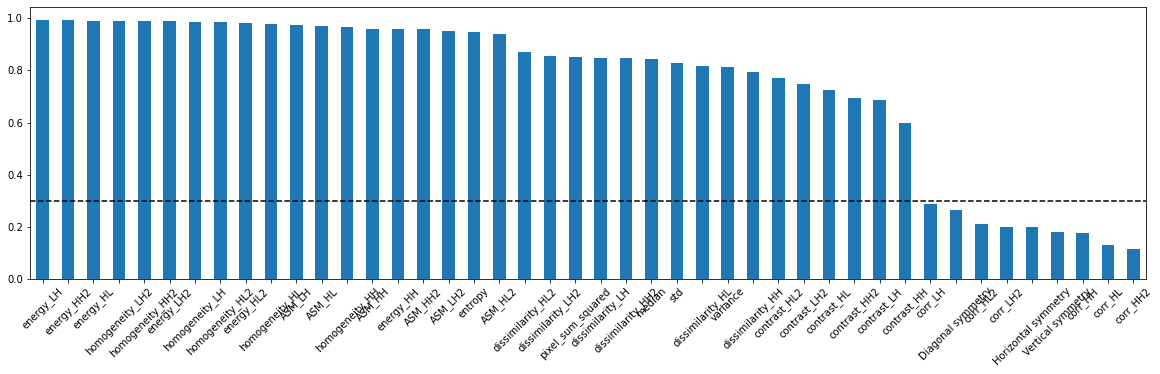

In [8]:
test = np.sqrt(corr_matrix.iloc[:,0]**2+corr_matrix.iloc[:,1]**2)
fig = plt.figure()
ax = test.sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=45)
ax.axhline(0.3,color='black',linestyle='--')
fig.set_figheight(5)
fig.set_figwidth(20)

### Display images in feature space

It seems 2D plots cannot describe clearly the separability between any pair of features.

<AxesSubplot:xlabel='homogeneity_LH', ylabel='entropy'>

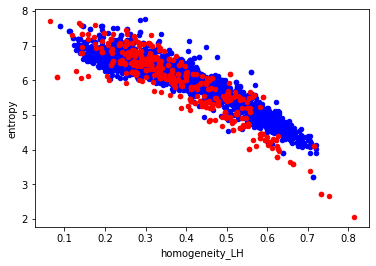

In [9]:
# Display different groups of pictures in different feature spaces to see their separability
healthy = df[df['tumour']==True]
sick = df[df['tumour']==False]
# front = df[df['perspective']=='front']

f1 = 'homogeneity_LH'
f2 = 'entropy'
ax = healthy.plot(f1,f2,kind='scatter',color='blue')
sick.plot(f1,f2,kind='scatter',color='red',ax=ax)
# front.plot(f1,f2,kind='scatter',color='green',ax=ax)


## Classification

In order to validate the performance of the different algorithms hereby presented it is essential to separate the given data into training, validation and test sets. Training data is used to define the parameters of the different classifiers, the validation set is used as a means to perform an initial test of the models on unseen data as well as to tune hyper-parameters and the test data is applied at the end of the parameter and hyper-parameter optimisation process to evaluate the generalisation error performance of the trained models. The chosen technique to perform validation is K-folding. This technique is chosen because it is commonly used in the literature and it performs non-exhaustive cross-validation, hence reducing computational cost. Particularly, it is decided to split training and validation sets with the standard 5:1 ratio present in the literature (i.e. 80% to 20%).

### Non-deep learning methods

Model selection is achieved by first comparing the performance of all estimators. A pipeline is created for each of them which combines the application of PCA dimensionality reduction, 5-fold cross-validation and a grid search over relevant hyper-parameters for each model. This gives an insight of how capable a predictor is of describing the given data. Based on three metrics, namely, accuracy, precision and recall (the last two are combined into the F1 metric, which is used as objective function for the gridsearch), the best performing algorithm is chosen. 

In [64]:
# Generate training pipeline for models with PCA
pipe = []
pipe.append(Pipeline([('reduce_dim',PCA()),('clf',neighbors.KNeighborsClassifier())]))
pipe.append(Pipeline([('reduce_dim',PCA()),('clf',discriminant_analysis.LinearDiscriminantAnalysis())]))
pipe.append(Pipeline([('reduce_dim',PCA()),('clf',naive_bayes.GaussianNB())]))
pipe.append(Pipeline([('reduce_dim',PCA()),('clf',LogisticRegression())]))
pipe.append(Pipeline([('reduce_dim',PCA()),('clf',svm.SVC())]))
pipe.append(Pipeline([('reduce_dim',PCA()),('clf',DecisionTreeClassifier(criterion='entropy'))]))
pipe.append(Pipeline([('reduce_dim',PCA()),('clf',RandomForestClassifier(criterion='entropy'))]))

# K-fold splitting
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

tuned_parameters = []
# Grid search space for models
tuned_parameters.append(dict(
    reduce_dim__n_components=[2,5,10,15],
    clf__n_neighbors=list(range(1,10)), # number of neighbours
    clf__p=list(range(1,10)) # distance metric (Minkowski order)
))

tuned_parameters.append(dict(
    reduce_dim__n_components=[2,5,10,15],
    clf__solver=['svd','lsqr','eigen'] # LDA solver
))

tuned_parameters.append(dict(
    reduce_dim__n_components=[2,5,10,15],
    clf__var_smoothing=[1e-8,1e-9,1e-10] # variance smoothing
))

tuned_parameters.append(dict(
    reduce_dim__n_components=[2,5,10,15],
    clf__C=[0.1,0.5,1] # inverse of regularisation
))

tuned_parameters.append(dict(
    reduce_dim__n_components=[2,5,10,15],
    clf__C=[0.1,0.5,1], # inverse of regularisation
    clf__kernel=['rbf','poly','sigmoid']
))

tuned_parameters.append(dict(
    reduce_dim__n_components=[2,5,10,15],
))

tuned_parameters.append(dict(
    reduce_dim__n_components=[2,5,10,15],
))

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'kNN', 1: 'LDA', 2: 'NB', 3: 'LR', 
		4: 'SVM', 5: 'DT', 6: 'RF'}

# Model classifier training
gridsearch = []
for i in range(len(pipe)):
    gridsearch.append(GridSearchCV(pipe[i],tuned_parameters[i],scoring='f1',cv=kfold))

    gridsearch[i].fit(X_resampled,y_resampled)

    print('Estimator: {}'.format(grid_dict[i]))
    print("Best parameters set found on development set: {}".format(gridsearch[i].best_params_))
    y_true,y_pred = y_test,gridsearch[i].predict(X_test)
    results = precision_recall_fscore_support(y_true, y_pred, average='macro')
    print("Best training metrics: Accuracy: {}, Recall: {}, Precision: {}, F1: {}".format(accuracy_score(y_true,y_pred),results[0],results[1],results[2]))
    print()
    

Estimator: kNN
Best parameters set found on development set: {'clf__n_neighbors': 1, 'clf__p': 2, 'reduce_dim__n_components': 15}
Best training metrics: Accuracy: 0.9433333333333334, Recall: 0.8851485148514852, Precision: 0.8989183704311405, F1: 0.8918368645415792

Estimator: LDA
Best parameters set found on development set: {'clf__solver': 'svd', 'reduce_dim__n_components': 10}
Best training metrics: Accuracy: 0.815, Recall: 0.6762058804689002, Precision: 0.7375483063105852, F1: 0.6964102564102563

Estimator: NB
Best parameters set found on development set: {'clf__var_smoothing': 1e-08, 'reduce_dim__n_components': 15}
Best training metrics: Accuracy: 0.8366666666666667, Recall: 0.7091485235925652, Precision: 0.7864159416222285, F1: 0.7346761966645008

Estimator: LR
Best parameters set found on development set: {'clf__C': 0.1, 'reduce_dim__n_components': 15}
Best training metrics: Accuracy: 0.825, Recall: 0.6906187944398181, Precision: 0.7569787776074612, F1: 0.7128205128205127

Estima

Consider applying Adaboost or Bagging on the best performing model to improve the performance. Both methods improve the performance.

*Note: `Adaboost` cannot be applied to kNN because it does not support sample_weights, it will be applied to the second best classifier.*

In [69]:
# Apply Bagging or Boosting
adaboost_clf = Pipeline([('reduce_dim',PCA(n_components=15)),('clf',AdaBoostClassifier(RandomForestClassifier(criterion='entropy'),n_estimators=100))])
bagging_clf = Pipeline([('reduce_dim',PCA(n_components=15)),('clf',BaggingClassifier(neighbors.KNeighborsClassifier(n_neighbors=1,p=2),n_estimators=100))])

adaboost_clf.fit(X_resampled,y_resampled)
bagging_clf.fit(X_resampled,y_resampled)

print('Estimator: AdaBoost')
y_true,y_pred = y_test,adaboost_clf.predict(X_test)
results = precision_recall_fscore_support(y_true, y_pred, average='macro')
print("Best training metrics: Accuracy: {}, Recall: {}, Precision: {}, F1: {}".format(accuracy_score(y_true,y_pred),results[0],results[1],results[2]))
print()

print('Estimator: Bagging')
y_true,y_pred = y_test,bagging_clf.predict(X_test)
results = precision_recall_fscore_support(y_true, y_pred, average='macro')
print("Best training metrics: Accuracy: {}, Recall: {}, Precision: {}, F1: {}".format(accuracy_score(y_true,y_pred),results[0],results[1],results[2]))
print()

Estimator: AdaBoost
Best training metrics: Accuracy: 0.925, Recall: 0.8484226359866656, Precision: 0.8700641205552797, F1: 0.8586971880740426

Estimator: Bagging
Best training metrics: Accuracy: 0.9433333333333334, Recall: 0.8851485148514852, Precision: 0.8989183704311405, F1: 0.8918368645415792



### Deep learning methods

In addition to non-deep learning methods a simple 1-layer NN was implemented to compare its raw performance with that of non-deep learning models. The accuracy, precision and recall measures are approximately the same as those of the optimised RF but the training time is much larger. Furthermore, there is no intelligibility, the NN acts as a "black box".

*Note: for the sake of learning different approaches DL algorithms have been developed using both `tensorflow` and `pytorch`.*

In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_resampled)
encoded_Y = encoder.transform(y_resampled)

# Baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(np.shape(X_resampled)[1],input_dim=10,activation='relu'))
	model.add(Dense(1,input_dim=np.shape(X_resampled)[1],activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
	return model

# Evaluate model with standardised dataset
clf = KerasClassifier(build_fn=create_baseline,epochs=100,batch_size=5,verbose=0)
kfold = StratifiedKFold(n_splits=5,shuffle=True)

# Create training pipeline
DL_pipe = Pipeline([('reduce_dim',PCA(n_components=15)),('clf',clf)])

DL_pipe.fit(X_resampled,y_resampled)

print('Estimator: 1-layer NN')
y_true,y_pred = y_test,gridsearch[i].predict(X_test)
results = precision_recall_fscore_support(y_true, y_pred, average='macro')
print("Best training metrics: Accuracy: {}, Recall: {}, Precision: {}, F1: {}".format(accuracy_score(y_true,y_pred),results[0],results[1],results[2]))


Estimator: 1-layer NN
Best training metrics: Accuracy: 0.9333333333333333, Recall: 0.8804036261098553, Precision: 0.8524147757939506, F1: 0.8655642938764536


# Task B

### Redefine labels

In [2]:
# Create a feature matrix X(NxM) where N = number of data samples and M = number of features 
# Create a labels vector y(Nx1)

X = df.iloc[:,5:].to_numpy() # remove the first 5 columns since they are not features
y = df['label']

scaler = MinMaxScaler() # normalise data
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.2)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Use SVMSMOTE to over-sample the dataset
X_resampled,y_resampled = SVMSMOTE().fit_resample(X_train,y_train)

print(np.shape(X_resampled))
print(np.shape(y_resampled))

(2752, 44)
(2752,)


### Non-deep learning methods

For the sake of comparison, the non-deep learning methods implemented for Task A are reused in Task B. The performance is not very good. It seems Random Forests still perform best than any other classifier.

In [51]:
# Generate training pipeline for models with PCA
pipe = []
pipe.append(Pipeline([('reduce_dim',PCA()),('clf',neighbors.KNeighborsClassifier())]))
pipe.append(Pipeline([('reduce_dim',PCA()),('clf',discriminant_analysis.LinearDiscriminantAnalysis())]))
pipe.append(Pipeline([('reduce_dim',PCA()),('clf',naive_bayes.GaussianNB())]))
pipe.append(Pipeline([('reduce_dim',PCA()),('clf',LogisticRegression())]))
pipe.append(Pipeline([('reduce_dim',PCA()),('clf',svm.SVC())]))
pipe.append(Pipeline([('reduce_dim',PCA()),('clf',DecisionTreeClassifier(criterion='entropy'))]))
pipe.append(Pipeline([('reduce_dim',PCA()),('clf',RandomForestClassifier(criterion='entropy'))]))

# # k-fold splitting
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

tuned_parameters = []
# Grid search space for models
tuned_parameters.append(dict(
    reduce_dim__n_components=[2,5,10],
    clf__n_neighbors=list(range(1,10)), # number of neighbours
    clf__p=list(range(1,10)) # distance metric (Minkowski order)
))

tuned_parameters.append(dict(
    reduce_dim__n_components=[2,5,10],
    clf__solver=['svd','lsqr','eigen'] # LDA solver
))

tuned_parameters.append(dict(
    reduce_dim__n_components=[2,5,10],
    clf__var_smoothing=[1e-8,1e-9,1e-10] # variance smoothing
))

tuned_parameters.append(dict(
    reduce_dim__n_components=[2,5,10],
    clf__C=[0.1,0.5,1] # inverse of regularisation
))

tuned_parameters.append(dict(
    reduce_dim__n_components=[2,5,10],
    clf__C=[0.1,0.5,1], # inverse of regularisation
    clf__kernel=['rbf','poly','sigmoid']
))

tuned_parameters.append(dict(
    reduce_dim__n_components=[2,5,10],
))

tuned_parameters.append(dict(
    reduce_dim__n_components=[2,5,10],
))

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'kNN', 1: 'LDA', 2: 'NB', 3: 'LR', 
		4: 'SVM', 5: 'DT', 6: 'RF'}

# Model classifier training
gridsearch = []
for i in range(len(pipe)):
    gridsearch.append(GridSearchCV(pipe[i],tuned_parameters[i],scoring='f1_weighted',cv=kfold))

    gridsearch[i].fit(X_resampled,y_resampled)

    print('Estimator: {}'.format(grid_dict[i]))
    print("Best parameters set found on development set: {}".format(gridsearch[i].best_params_))
    y_true,y_pred = y_test,gridsearch[i].predict(X_test)
    results = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print("Best training metrics: Accuracy: {}, Recall: {}, Precision: {}, F1: {}".format(accuracy_score(y_true,y_pred),results[0],results[1],results[2]))
    print()
    

Estimator: kNN
Best parameters set found on development set: {'clf__n_neighbors': 1, 'clf__p': 2, 'reduce_dim__n_components': 10}
Best training metrics: Accuracy: 0.75, Recall: 0.7511042832882743, Precision: 0.75, F1: 0.7493772832533553

Estimator: LDA
Best parameters set found on development set: {'clf__solver': 'lsqr', 'reduce_dim__n_components': 10}
Best training metrics: Accuracy: 0.5716666666666667, Recall: 0.5680876811685536, Precision: 0.5716666666666667, F1: 0.5694785593009093

Estimator: NB
Best parameters set found on development set: {'clf__var_smoothing': 1e-08, 'reduce_dim__n_components': 10}
Best training metrics: Accuracy: 0.55, Recall: 0.5510104219497212, Precision: 0.55, F1: 0.5411893577011295

Estimator: LR
Best parameters set found on development set: {'clf__C': 1, 'reduce_dim__n_components': 10}
Best training metrics: Accuracy: 0.5883333333333334, Recall: 0.5862963103408145, Precision: 0.5883333333333334, F1: 0.5855867950872609

Estimator: SVM
Best parameters set fo

Attempt bagging and boosting on best performing model

In [52]:
# Apply Bagging or Boosting
adaboost_clf = Pipeline([('reduce_dim',PCA(n_components=10)),('clf',AdaBoostClassifier(RandomForestClassifier(criterion='entropy'),n_estimators=100))])
bagging_clf = Pipeline([('reduce_dim',PCA(n_components=10)),('clf',BaggingClassifier(RandomForestClassifier(criterion='entropy'),n_estimators=100))])

adaboost_clf.fit(X_resampled,y_resampled)
bagging_clf.fit(X_resampled,y_resampled)

print('Estimator: AdaBoost')
y_true,y_pred = y_test,adaboost_clf.predict(X_test)
results = precision_recall_fscore_support(y_true, y_pred, average='macro')
print("Best training metrics: Accuracy: {}, Recall: {}, Precision: {}, F1: {}".format(accuracy_score(y_true,y_pred),results[0],results[1],results[2]))
print()

print('Estimator: Bagging')
y_true,y_pred = y_test,bagging_clf.predict(X_test)
results = precision_recall_fscore_support(y_true, y_pred, average='macro')
print("Best training metrics: Accuracy: {}, Recall: {}, Precision: {}, F1: {}".format(accuracy_score(y_true,y_pred),results[0],results[1],results[2]))
print()

Estimator: AdaBoost
Best training metrics: Accuracy: 0.75, Recall: 0.7573480979846041, Precision: 0.7494877600889163, F1: 0.7525167797783292

Estimator: Bagging
Best training metrics: Accuracy: 0.74, Recall: 0.7442069309656548, Precision: 0.7379946580048703, F1: 0.7406252735888975



In [54]:
y_true,y_pred = y_test,adaboost_clf.predict(X_test)

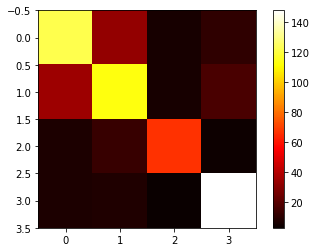

In [55]:
plt.imshow(confusion_matrix(y_true,y_pred),cmap='hot')
plt.colorbar()

### Deep learning methods

Simple 2-layer NN

Define model architecture, adjut input to appropriate DL form, fit and test model

In [13]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)
X_encoded = X_resampled.astype(np.float32)
y_encoded = y_encoded.astype(np.int64)

class L2NeuralNetwork(nn.Module):
    def __init__(self):
        super(L2NeuralNetwork, self).__init__()

        self.dense0 = nn.Linear(15, 150)
        self.dense1 = nn.Linear(150, 150)
        self.output = nn.Linear(150, 4)

    def forward(self, X, **kwargs):
        X = F.relu(self.dense0(X))
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X),dim=1)
        return X

net = NeuralNetClassifier(
    L2NeuralNetwork,
    max_epochs=200,
    lr=0.01,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.Adamax,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
	device='cuda'
)

pipe = Pipeline([('reduce_dim',PCA(n_components=15)),('clf',net)])

# K-fold splitting
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

# Grid search space for models
tuned_parameters = dict(
    clf__lr = [0.0001,0.001,0.01,0.1],
    clf__criterion = [torch.nn.CrossEntropyLoss,torch.nn.NLLLoss],
    clf__optimizer= [torch.optim.Adam,torch.optim.SGD,torch.optim.Adamax]
)

gs = GridSearchCV(pipe,tuned_parameters,scoring='accuracy',cv=kfold)

gs.fit(X_encoded,y_encoded)

print('Estimator: 2-layer NN')
X_test_encoded = X_test.astype(np.float32)
print("Best parameters set found on development set: {}".format(gs.best_params_))
y_true,y_pred = le.transform(y_test),gs.predict(X_test_encoded)
results = precision_recall_fscore_support(y_true, y_pred, average='macro')
print("Best training metrics: Accuracy: {}, Recall: {}, Precision: {}, F1: {}".format(accuracy_score(y_true,y_pred),results[0],results[1],results[2]))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3854       0.3832        1.3835  0.0667
      2        1.3826       0.4150        1.3805  0.0613
      3        1.3798       0.4127        1.3774  0.0605
      4        1.3769       0.4240        1.3740  0.0599
      5        1.3736       0.4354        1.3702  0.0589
      6        1.3700       0.4354        1.3659  0.0609
      7        1.3659       0.4399        1.3612  0.0667
      8        1.3614       0.4467        1.3558  0.0668
      9        1.3565       0.4467        1.3498  0.0618
     10        1.3511       0.4490        1.3433  0.0619
     11        1.3451       0.4512        1.3364  0.0637
     12        1.3388       0.4558        1.3288  0.0639
     13        1.3318       0.4671        1.3208  0.0658
     14        1.3244       0.4762        1.3123  0.0673
     15        1.3166       0.4830        1.3036  0.0614
     16        1.3086       0.4

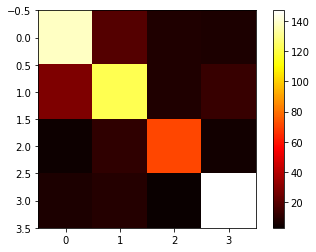

In [14]:
plt.imshow(confusion_matrix(y_true,y_pred),cmap='hot')
plt.colorbar()

CNN

Separate data into training and testing, generate CNN architecture

*We will design a baseline model with a VGG-type structure. That is, blocks of convolutional layers with small 3×3 filters followed by a max pooling layer, with this pattern repeating with a doubling in the number of filters with each block added.*

*Specifically, each block will have two convolutional layers with 3×3 filters, ReLU activation and He weight initialization with same padding, ensuring the output feature maps have the same width and height. These will be followed by a max pooling layer with a 3×3 kernel. Three of these blocks will be used with 32, 64 and 128 filters respectively.*

*The output of the final pooling layer will be flattened and fed to a fully connected layer for interpretation then finally to an output layer for prediction. The model must produce a 4-element vector with a prediction between 0 and 1 for each output class.*

*Given this is a multi-class classification problem, we will use a softmax activation function and the categorical cross entropy loss function.*

*The model will be optimized with mini-batch stochastic gradient descent with a conservative learning rate of 0.01 and a momentum of 0.9, and the model will keep track of the “fbeta” metric during training.*

# Notes